## Training and Developing Models using the Saved Preproccessed Dataset.
### Model Selection Experiments.

#### Tuning with Grid Search method.

##### The codes below train 5 claasfiers: Decision Tree, Random Forest, XGBoost, LightGBM and Logistic Regression using Leave-One-Out Cross Validation(LOOCV) within GridSearchCV to understand which performs better on the dataset. 
##### Evaluate the final model on the full dataset using Accuracy, Precision, Recall, F1 score and Area under the curve(AUC) 
##### Display their performance comparison table and bar chart.


🔎 Tuning Decision Tree...
✅ Best Params: {'max_depth': 3, 'min_samples_split': 2}
   Scores -> Acc: 0.673, Prec: 0.794, Rec: 0.482, F1: 0.600, AUC: 0.749
   Time taken: 3.50 sec

🔎 Tuning Random Forest...
✅ Best Params: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 200}
   Scores -> Acc: 0.836, Prec: 0.828, Rec: 0.857, F1: 0.842, AUC: 0.926
   Time taken: 96.13 sec

🔎 Tuning Logistic Regression...
✅ Best Params: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
   Scores -> Acc: 0.618, Prec: 0.621, Rec: 0.643, F1: 0.632, AUC: 0.683
   Time taken: 1.07 sec

🔎 Tuning XGBoost...
✅ Best Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
   Scores -> Acc: 0.800, Prec: 0.793, Rec: 0.821, F1: 0.807, AUC: 0.876
   Time taken: 7.14 sec

🔎 Tuning LightGBM...
✅ Best Params: {'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 100}
   Scores -> Acc: 0.718, Prec: 0.727, Rec: 0.714, F1: 0.721, AUC: 0.801
   Time taken: 11.41 sec

📊 Comparison Results with Tuned Models:

   

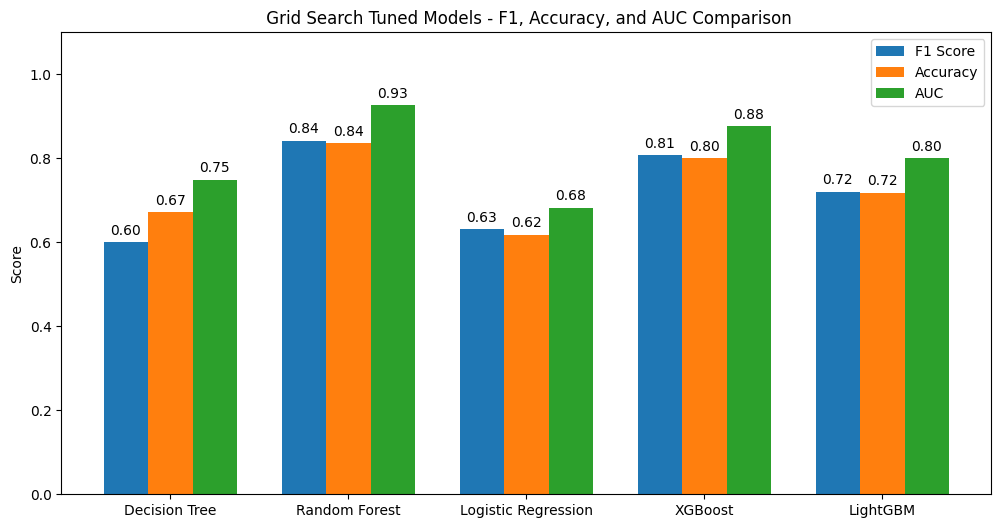

In [6]:
# --- Tuned Model Comparison with LOOCV ---

import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

from sklearn.model_selection import LeaveOneOut, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# --- Suppress Warnings ---
# Silence warnings from xgboost, joblib, and lightgbm
warnings.filterwarnings("ignore", category=UserWarning, module="xgboost")
warnings.filterwarnings("ignore", category=UserWarning, module="joblib")
warnings.filterwarnings("ignore", category=UserWarning, module="lightgbm")
# Optional: silence absolutely everything (uncomment if needed)
# warnings.filterwarnings("ignore")

# Fix joblib "physical cores" warning on Windows
os.environ["LOKY_MAX_CPU_COUNT"] = "4"  # Change 4 to match your CPU cores

# --- Load dataset ---
file_path = r"C:\Users\USER\Documents\Happy customers\df_transformed.pkl"
df = pd.read_pickle(file_path)

# Features & target
X = df.drop(columns=["Y"])
y = df["Y"]

# --- Define models & grids ---
models_and_params = {
    "Decision Tree": (
        DecisionTreeClassifier(random_state=42),
        {"max_depth": [None, 3, 5], "min_samples_split": [2, 5]}
    ),
    "Random Forest": (
        RandomForestClassifier(random_state=42),
        {"n_estimators": [100, 200],
         "max_depth": [None, 5, 10],
         "min_samples_split": [2, 5]}
    ),
    "Logistic Regression": (
        LogisticRegression(max_iter=500, random_state=42),
        {"C": [0.1, 1, 10], "penalty": ["l2"], "solver": ["lbfgs"]}
    ),
    "XGBoost": (
        XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42, verbosity=0),
        {"n_estimators": [50, 100],
         "max_depth": [3, 5],
         "learning_rate": [0.05, 0.1]}
    ),
    "LightGBM": (
        LGBMClassifier(random_state=42, verbose=-1),
        {"n_estimators": [50, 100],
         "max_depth": [-1, 5],
         "learning_rate": [0.05, 0.1]}
    ),
}

# --- LOOCV setup ---
loo = LeaveOneOut()

# --- Storage for results ---
results = []

# --- Loop through models ---
for name, (model, param_grid) in models_and_params.items():
    print(f"\n🔎 Tuning {name}...")
    start = time.time()
    
    grid = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=loo,
        scoring="f1",
        n_jobs=-1
    )
    grid.fit(X, y)
    best_model = grid.best_estimator_
    
    # Evaluate on full dataset
    y_pred = best_model.predict(X)
    y_prob = best_model.predict_proba(X)[:, 1] if hasattr(best_model, "predict_proba") else y_pred
    
    acc = accuracy_score(y, y_pred)
    prec = precision_score(y, y_pred)
    rec = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    auc = roc_auc_score(y, y_prob)
    
    end = time.time()
    duration = end - start
    
    print(f" Best Params: {grid.best_params_}")
    print(f"   Scores -> Acc: {acc:.3f}, Prec: {prec:.3f}, Rec: {rec:.3f}, F1: {f1:.3f}, AUC: {auc:.3f}")
    print(f"   Time taken: {duration:.2f} sec")
    
    results.append([name, acc, prec, rec, f1, auc, grid.best_params_])

# --- Comparison Table ---
results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score", "AUC", "Best Params"])
print("\n Comparison Results with Tuned Models:\n")
print(results_df)

# --- Grouped bar plot for F1, Accuracy, and AUC ---
plt.figure(figsize=(12, 6))

# Metrics to plot
metrics = ["F1 Score", "Accuracy", "AUC"]
bar_width = 0.25
x = np.arange(len(results_df))  # the label locations

# Plot each metric
for i, metric in enumerate(metrics):
    plt.bar(x + i*bar_width, results_df[metric], width=bar_width, label=metric)

# Annotate bars with metric values
for i, metric in enumerate(metrics):
    for j, val in enumerate(results_df[metric]):
        plt.text(j + i*bar_width, val + 0.01, f"{val:.2f}", ha='center', va='bottom', fontsize=10)

# Labels and legend
plt.xticks(x + bar_width, results_df["Model"])
plt.ylabel("Score")
plt.ylim(0, 1.1)
plt.title(" Grid Search Tuned Models - F1, Accuracy, and AUC Comparison")
plt.legend()
plt.show()

#### From the  optimistic results(not the genaralization ability in reality) above, the Random Forest out performed other classifiers with Accuracy, Precision, Recall, F1 Score and AUC values of 0.84, 0.83, 0.86, 0.84 and 0.93 repectively. 

## Tuning with HyperOpt method.
##### The codes below train 5 claasfiers: Decision Tree, Random Forest, XGBoost, LightGBM and Logistic Regression using Leave-One-Out Cross Validation(LOOCV) within HyperOptCV to understand which performs better on the dataset. 
##### Evaluate the final model on the full dataset using Accuracy, Precision, Recall, F1 score and Area under the curve(AUC) 
##### Display their performance comparison table and bar chart.


🔎 Hyperopt Tuning Decision Tree...
100%|███████████████████████████████████████████████| 20/20 [00:04<00:00,  4.41trial/s, best loss: -0.6122448979591837]
✅ Best Params: {'max_depth': 3, 'min_samples_split': 5}
   Scores -> Acc: 0.673, Prec: 0.794, Rec: 0.482, F1: 0.600, AUC: 0.749
   Time taken: 4.55 sec

🔎 Hyperopt Tuning Random Forest...
100%|███████████████████████████████████████████████| 20/20 [05:29<00:00, 16.49s/trial, best loss: -0.5370370370370371]
✅ Best Params: {'n_estimators': 200, 'max_depth': 5, 'min_samples_split': 5}
   Scores -> Acc: 0.809, Prec: 0.807, Rec: 0.821, F1: 0.814, AUC: 0.899
   Time taken: 330.03 sec

🔎 Hyperopt Tuning Logistic Regression...
100%|███████████████████████████████████████████████| 20/20 [00:07<00:00,  2.61trial/s, best loss: -0.5862068965517241]
✅ Best Params: {'C': np.float64(4.239462667878078), 'penalty': 'l2', 'solver': 'lbfgs', 'max_iter': 500}
   Scores -> Acc: 0.618, Prec: 0.621, Rec: 0.643, F1: 0.632, AUC: 0.683
   Time taken: 7.70 se

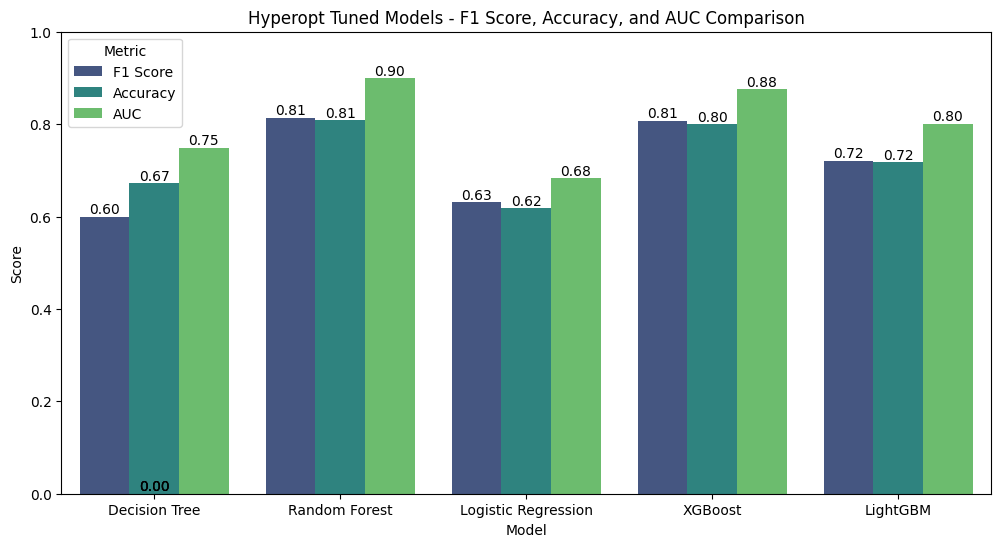

In [13]:
# --- Tuned Model Comparison with LOOCV using Hyperopt ---

import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import LeaveOneOut
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
import warnings
warnings.filterwarnings("ignore")

# --- Load dataset ---
file_path = r"C:\Users\USER\Documents\Happy customers\df_transformed.pkl"
df = pd.read_pickle(file_path)

# Features & target
X = df.drop(columns=["Y"])
y = df["Y"]

# --- Define models ---
model_classes = {
    "Decision Tree": DecisionTreeClassifier,
    "Random Forest": RandomForestClassifier,
    "Logistic Regression": LogisticRegression,
    "XGBoost": XGBClassifier,
    "LightGBM": LGBMClassifier
}

# --- Define Hyperopt search spaces ---
search_spaces = {
    "Decision Tree": {
        "max_depth": hp.choice("max_depth_dt", [None, 3, 5]),
        "min_samples_split": hp.choice("min_samples_split_dt", [2, 5])
    },
    "Random Forest": {
        "n_estimators": hp.choice("n_estimators_rf", [100, 200]),
        "max_depth": hp.choice("max_depth_rf", [None, 5, 10]),
        "min_samples_split": hp.choice("min_samples_split_rf", [2, 5])
    },
    "Logistic Regression": {
        "C": hp.loguniform("C_lr", np.log(0.1), np.log(10)),
        "penalty": "l2",
        "solver": "lbfgs",
        "max_iter": 500
    },
    "XGBoost": {
        "n_estimators": hp.choice("n_estimators_xgb", [50, 100]),
        "max_depth": hp.choice("max_depth_xgb", [3, 5]),
        "learning_rate": hp.choice("learning_rate_xgb", [0.05, 0.1]),
        "use_label_encoder": False,
        "eval_metric": "logloss"
    },
    "LightGBM": {
        "n_estimators": hp.choice("n_estimators_lgb", [50, 100]),
        "max_depth": hp.choice("max_depth_lgb", [-1, 5]),
        "learning_rate": hp.choice("learning_rate_lgb", [0.05, 0.1])
    }
}

# --- Objective function ---
def objective(params, model_name):
    # Convert integer params to Python int
    int_keys = ["max_depth", "min_samples_split", "n_estimators"]
    for key in int_keys:
        if key in params and params[key] is not None:
            params[key] = int(params[key])

    # Build model
    ModelClass = model_classes[model_name]
    if model_name == "LightGBM":
        model = ModelClass(**params, verbose=-1, n_jobs=1)  
    elif model_name == "Random Forest":
        model = ModelClass(**params, n_jobs=1)  
        model = ModelClass(**params)  

    # LOOCV predictions
    y_preds = []
    y_trues = []
    for train_idx, test_idx in loo.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_preds.append(y_pred[0])
        y_trues.append(y_test.values[0])
    
    
    # Evaluate F1 score
    f1 = f1_score(y_trues, y_preds)
    return {"loss": -f1, "status": STATUS_OK}

# --- Run Hyperopt for each model ---
results = []

for name in model_classes.keys():
    print(f"\n🔎 Hyperopt Tuning {name}...")
    start = time.time()
    trials = Trials()
    
    best = fmin(
        fn=lambda params: objective(params, name),
        space=search_spaces[name],
        algo=tpe.suggest,
        max_evals=20,
        trials=trials,
        rstate=np.random.default_rng(42)
    )
    
    # Build best model with proper type conversion
    best_params = best.copy()
    # Map Hyperopt choice indexes to actual values
    if name == "Decision Tree":
        best_params["max_depth"] = [None, 3, 5][best["max_depth_dt"]]
        best_params["min_samples_split"] = [2, 5][best["min_samples_split_dt"]]
        best_params.pop("max_depth_dt")
        best_params.pop("min_samples_split_dt")
    elif name == "Random Forest":
        best_params["n_estimators"] = [100, 200][best["n_estimators_rf"]]
        best_params["max_depth"] = [None, 5, 10][best["max_depth_rf"]]
        best_params["min_samples_split"] = [2, 5][best["min_samples_split_rf"]]
        for k in ["n_estimators_rf", "max_depth_rf", "min_samples_split_rf"]:
            best_params.pop(k)
    elif name == "Logistic Regression":
        best_params["C"] = best["C_lr"]
        best_params.pop("C_lr")
        best_params["penalty"] = "l2"
        best_params["solver"] = "lbfgs"
        best_params["max_iter"] = 500
    elif name == "XGBoost":
        best_params["n_estimators"] = [50, 100][best["n_estimators_xgb"]]
        best_params["max_depth"] = [3, 5][best["max_depth_xgb"]]
        best_params["learning_rate"] = [0.05, 0.1][best["learning_rate_xgb"]]
        best_params.pop("n_estimators_xgb")
        best_params.pop("max_depth_xgb")
        best_params.pop("learning_rate_xgb")
        best_params["use_label_encoder"] = False
        best_params["eval_metric"] = "logloss"
    elif name == "LightGBM":
        best_params["n_estimators"] = [50, 100][best["n_estimators_lgb"]]
        best_params["max_depth"] = [-1, 5][best["max_depth_lgb"]]
        best_params["learning_rate"] = [0.05, 0.1][best["learning_rate_lgb"]]
        best_params.pop("n_estimators_lgb")
        best_params.pop("max_depth_lgb")
        best_params.pop("learning_rate_lgb")
    
    # Convert integer params to int
    for key in ["n_estimators", "max_depth", "min_samples_split"]:
        if key in best_params and best_params[key] is not None:
            best_params[key] = int(best_params[key])
    
    # Train final model
    final_model = model_classes[name](**best_params)
    final_model.fit(X, y)
    
    # Evaluate
    y_pred = final_model.predict(X)
    y_prob = final_model.predict_proba(X)[:, 1] if hasattr(final_model, "predict_proba") else y_pred
    acc = accuracy_score(y, y_pred)
    prec = precision_score(y, y_pred)
    rec = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    auc_score = roc_auc_score(y, y_prob)
    
    end = time.time()
    duration = end - start
    
    print(f"✅ Best Params: {best_params}")
    print(f"   Scores -> Acc: {acc:.3f}, Prec: {prec:.3f}, Rec: {rec:.3f}, F1: {f1:.3f}, AUC: {auc_score:.3f}")
    print(f"   Time taken: {duration:.2f} sec")
    
    results.append([name, acc, prec, rec, f1, auc_score, best_params])

# --- Comparison Table ---
results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score", "AUC", "Best Params"])
print("\n📊 Comparison Results with Hyperopt Tuned Models:\n")
print(results_df)

# --- F1, Accuracy, and AUC Bar Plot with Annotations ---
plt.figure(figsize=(12, 6))
metrics = ["F1 Score", "Accuracy", "AUC"]

# Melt the dataframe for seaborn
results_melted = results_df.melt(id_vars="Model", value_vars=metrics, 
                                 var_name="Metric", value_name="Score")

ax = sns.barplot(data=results_melted, x="Model", y="Score", hue="Metric", palette="viridis")
plt.title("Hyperopt Tuned Models - F1 Score, Accuracy, and AUC Comparison")
plt.ylim(0, 1)  # since all metrics are between 0 and 1
plt.ylabel("Score")
plt.legend(title="Metric")

# Annotate bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.2f}', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='bottom', fontsize=10)

plt.show()

#### From the  optimistic results(not the genaralization ability in reality) above, the Random Forest out performed other classifiers with Accuracy, Precision, Recall, F1 Score and AUC values  of  0.81, 0.81, 0.82, 0.81 and 0.90 repectively.

### Comparing the performance of the Random Forst with Grid Search and HyperOpt hypperparameter tuning.
##### From the optimistic results above,  the Random Forest with Grid Serach method got the best results: Accuracy, Precision, Recall, F1 Score and AUC values of 0.84, 0.83, 0.86, 0.84 and 0.93 repectively. Against 0.81, 0.81, 0.82, 0.81 and 0.90 Accuracy, Precision, Recall, F1 Score and AUC values respectively from the HyperOpt.

### Evaluating the best performed model (The Random Forest); max_depth: 5, min_samples_split: 2, n_estimators: 200 obtained from the Grid Search method.

##### The code below evaluates two versions of the best Random Forest model obtained from GridSearchCV:

##### 1. On the full dataset – to obtain performance metrics (Accuracy, Precision, Recall, F1-score, and AUC) that are likely optimistic, but from which feature importance can be extracted.
##### 2. Using Leave-One-Out Cross-Validation (LOOCV) – to assess the model’s true generalization ability based on the same metrics (Accuracy, Precision, Recall, F1-score, and AUC).
##### Display their confusion matrix.
##### Plot and display their ROC curve
##### Save one that is evaluated on full dataset for feature importance extraction.


Random Forest Training Time (using best params): 0.23 seconds

Best Random Forest Parameters: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 200}

Random Forest Results on full dataset:
Full Dataset - Accuracy: 0.8364, Precision: 0.8276, Recall: 0.8571, F1 Score: 0.8421

Random Forest Results with LOOCV:
LOOCV - Accuracy: 0.5455, Precision: 0.5536, Recall: 0.5536, F1 Score: 0.5536


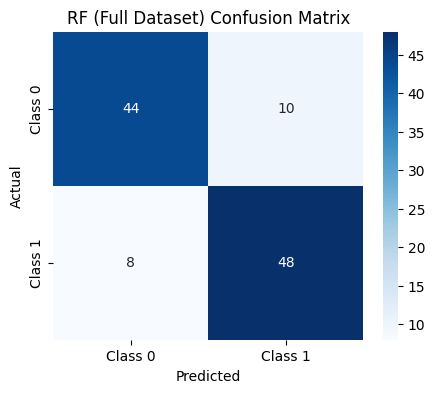

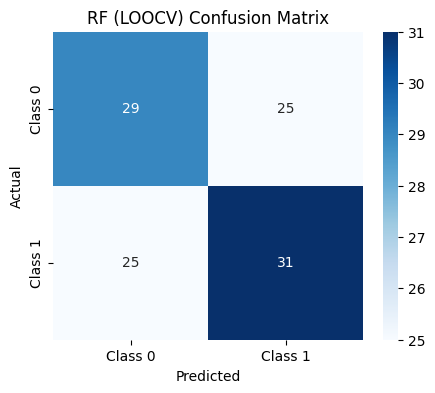

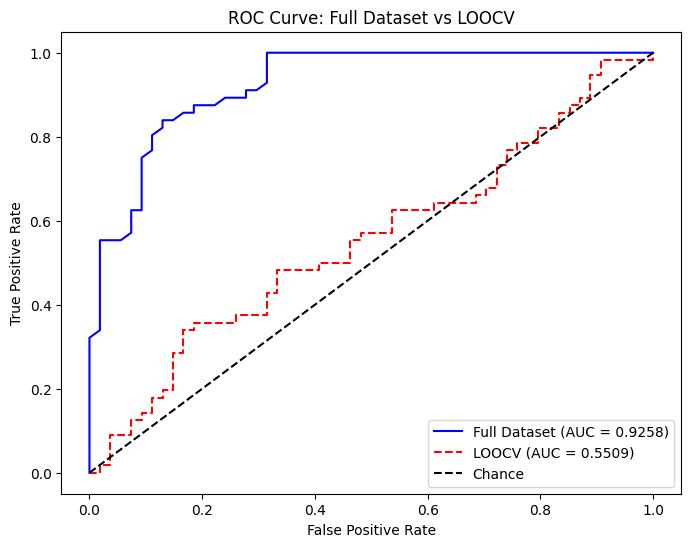

Random Forest model saved at: C:\Users\USER\Documents\Happy customers\rf_loocv_model.pkl


In [6]:
# RANDOM FOREST DEVELOPMENT WITH LOOCV (using best params directly)

import pandas as pd
import numpy as np
import time
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import LeaveOneOut
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix

# --- Load dataset ---
file_path = r"C:\Users\USER\Documents\Happy customers\df_transformed.pkl"
df = pd.read_pickle(file_path)

# --- Separate features and target ---
X = df.drop(columns=["Y"])  # Features
y = df["Y"]                 # Target variable

# --- Best params from GridSearch ---
best_params = {"max_depth": 5, "min_samples_split": 2, "n_estimators": 200}

# --- Leave-One-Out CV ---
loo = LeaveOneOut()

# Random Forest classifier with tuned params
rf = RandomForestClassifier(random_state=42, **best_params)

# --- Record start time ---
start_time = time.time()

# Fit the model on the whole dataset (for full dataset evaluation)
rf.fit(X, y)

# --- Record end time ---
end_time = time.time()
training_time = end_time - start_time
print(f"\nRandom Forest Training Time (using best params): {training_time:.2f} seconds")
print("\nBest Random Forest Parameters:", best_params)

# --- Evaluate on full dataset ---
def evaluate_model(model, X, y, dataset_name="Dataset"):
    y_pred = model.predict(X)
    acc = accuracy_score(y, y_pred)
    prec = precision_score(y, y_pred, average="binary")
    rec = recall_score(y, y_pred, average="binary")
    f1 = f1_score(y, y_pred, average="binary")
    print(f"{dataset_name} - Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1 Score: {f1:.4f}")
    return acc, prec, rec, f1, y_pred

print("\nRandom Forest Results on full dataset:")
full_acc, full_prec, full_rec, full_f1, y_pred_full = evaluate_model(rf, X, y, "Full Dataset")

# --- LOOCV Predictions ---
y_pred_loo = np.zeros(len(y))
y_prob_loo = np.zeros(len(y))

for train_index, test_index in loo.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    rf_loo = RandomForestClassifier(random_state=42, **best_params)
    rf_loo.fit(X_train, y_train)
    
    y_pred_loo[test_index] = rf_loo.predict(X_test)
    y_prob_loo[test_index] = rf_loo.predict_proba(X_test)[:, 1]

# --- Evaluate LOOCV predictions ---
loo_acc = accuracy_score(y, y_pred_loo)
loo_prec = precision_score(y, y_pred_loo, zero_division=0)
loo_rec = recall_score(y, y_pred_loo, zero_division=0)
loo_f1 = f1_score(y, y_pred_loo, zero_division=0)

print("\nRandom Forest Results with LOOCV:")
print(f"LOOCV - Accuracy: {loo_acc:.4f}, Precision: {loo_prec:.4f}, Recall: {loo_rec:.4f}, F1 Score: {loo_f1:.4f}")

# --- Confusion Matrices ---
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Class 0", "Class 1"],
                yticklabels=["Class 0", "Class 1"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

plot_confusion_matrix(y, y_pred_full, "RF (Full Dataset) Confusion Matrix")
plot_confusion_matrix(y, y_pred_loo, "RF (LOOCV) Confusion Matrix")

# --- ROC Curves: Full Dataset vs LOOCV ---
fpr_full, tpr_full, _ = roc_curve(y, rf.predict_proba(X)[:, 1])
roc_auc_full = auc(fpr_full, tpr_full)

fpr_loo, tpr_loo, _ = roc_curve(y, y_prob_loo)
roc_auc_loo = auc(fpr_loo, tpr_loo)

plt.figure(figsize=(8, 6))
plt.plot(fpr_full, tpr_full, label=f"Full Dataset (AUC = {roc_auc_full:.4f})", color='blue')
plt.plot(fpr_loo, tpr_loo, label=f"LOOCV (AUC = {roc_auc_loo:.4f})", color='red', linestyle='--')
plt.plot([0, 1], [0, 1], "k--", label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: Full Dataset vs LOOCV")
plt.legend(loc="lower right")
plt.show()

# --- Save the trained Random Forest model ---
model_save_path = r"C:\Users\USER\Documents\Happy customers\rf_loocv_model.pkl"
joblib.dump(rf, model_save_path)
print(f"Random Forest model saved at: {model_save_path}")

##### From the results above:

##### Full Dataset – Accuracy: 0.8364, Precision: 0.8276, Recall: 0.8571, F1-score: 0.8421

##### LOOCV – Accuracy: 0.5455, Precision: 0.5536, Recall: 0.5536, F1-score: 0.5536

##### The substantial drop in performance when moving from the full dataset to LOOCV indicates that the model is likely overfitting to the training data and does not generalize well.

### Extraction of  feature importance.
##### The codes below extract feature importance from the trained and saved model(Randonm Forest) and display them with bar charts.


Random Forest Feature Importance:
  Feature  Importance
0      X1    0.207127
4      X5    0.179272
2      X3    0.172723
1      X2    0.155298
3      X4    0.148684
5      X6    0.136897


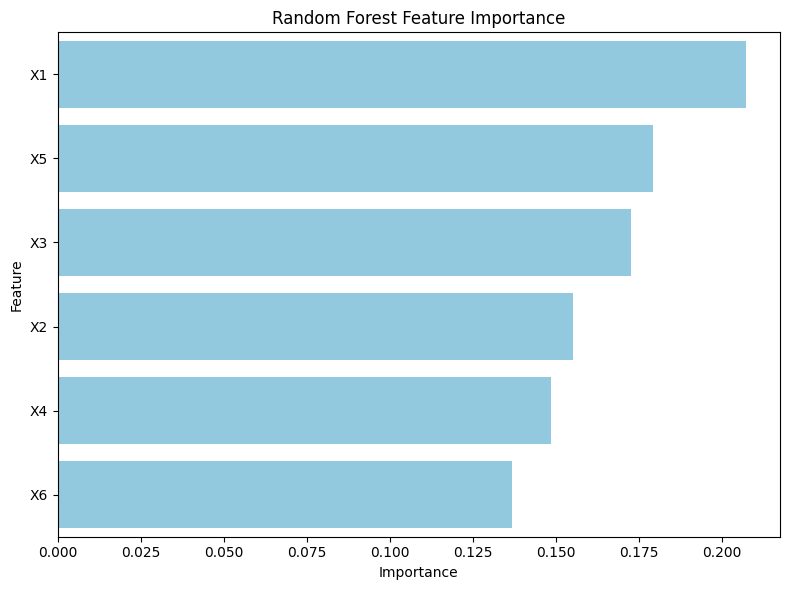

In [10]:


import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load dataset again (to recover feature names) ---
file_path =  r"C:\Users\USER\Documents\Happy customers\df_transformed.pkl"
df = pd.read_pickle(file_path)
X = df.drop(columns=["Y"])  # Features only

# --- Load the saved Random Forest model ---
model_save_path = r"C:\Users\USER\Documents\Happy customers\rf_loocv_model.pkl"
loaded_model = joblib.load(model_save_path)

# --- Extract Feature Importances ---
feature_importance = loaded_model.feature_importances_
feature_names = X.columns

# Create a DataFrame for easy visualization
fi_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)

print("\nRandom Forest Feature Importance:")
print(fi_df)

# --- Plot Feature Importance ---
plt.figure(figsize=(8, 6))
sns.barplot(x="Importance", y="Feature", data=fi_df, color="skyblue")  # single color instead of palette
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

#### From the result above, the feature importance are:
##### 1. X1 = My order was deliverd on time.
##### 2. X5 = I am satisfied with my courier.
##### 3. X3 = I ordered everything I wanted to order.
##### 4. X2 = Content of my order was as expected.
##### 5. X4 = I paid a good price.
##### 6. X6 = The app makes ordering easy for me.

## Feature Selection Appraoch to Improve Model Performance.

##### codes below train a random forest using 10-folds Stratified CV within GridSearch CV and feature selection approach(SelectBest).
##### Evaluate it in two settings: 
##### (i) on the full dataset, yielding optimistic performance scores useful for overfitting analysis, and 
##### (ii) using Stratified 10-Fold Cross-Validation, providing a more realistic estimate of generalization ability.

In [13]:
# --- Random Forest with Feature Selection and Stratified K-Fold CV ---

import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# --- Suppress Warnings ---
warnings.filterwarnings("ignore", category=UserWarning)
os.environ["LOKY_MAX_CPU_COUNT"] = "4"

# --- Load dataset ---
file_path = r"C:\Users\USER\Documents\Happy customers\df_transformed.pkl"
df = pd.read_pickle(file_path)

X = df.drop(columns=["Y"])
y = df["Y"]

# --- Stratified K-Fold setup ---
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# --- Random Forest pipeline with feature selection ---
rf_pipe = Pipeline([
    ("select", SelectKBest(score_func=f_classif)),
    ("clf", RandomForestClassifier(random_state=42))
])

# --- Param grid ---
rf_params = {
    "select__k": [2, 3, 4, "all"],
    "clf__n_estimators": [100, 200],
    "clf__max_depth": [None, 5, 10],
    "clf__min_samples_split": [2, 5]
}

print("\n🔎 Tuning Random Forest...")
start = time.time()

# GridSearch with Stratified CV
grid = GridSearchCV(
    estimator=rf_pipe,
    param_grid=rf_params,
    cv=cv,
    scoring="f1",
    n_jobs=-1
)
grid.fit(X, y)
best_rf_pipe = grid.best_estimator_

# --- Whole dataset evaluation ---
y_pred_full = best_rf_pipe.predict(X)
y_prob_full = best_rf_pipe.predict_proba(X)[:, 1]
acc_full = accuracy_score(y, y_pred_full)
prec_full = precision_score(y, y_pred_full, zero_division=0)
rec_full = recall_score(y, y_pred_full, zero_division=0)
f1_full = f1_score(y, y_pred_full, zero_division=0)
auc_full = roc_auc_score(y, y_prob_full)

print(f"✅ Whole-dataset evaluation")
print(f"   Acc: {acc_full:.3f}, Prec: {prec_full:.3f}, Rec: {rec_full:.3f}, "
      f"F1: {f1_full:.3f}, AUC: {auc_full:.3f}")

# --- Best params ---
print(f"✅ Best Params for Random Forest: {grid.best_params_}")

# --- Selected features ---
selected_mask = best_rf_pipe.named_steps['select'].get_support()
selected_features = X.columns[selected_mask]
print(f"✅ Selected features: {list(selected_features)}")

# --- Cross-validated predictions ---
y_pred_cv = cross_val_predict(best_rf_pipe, X, y, cv=cv, method="predict")
y_prob_cv = cross_val_predict(best_rf_pipe, X, y, cv=cv, method="predict_proba")[:, 1]
acc_cv = accuracy_score(y, y_pred_cv)
prec_cv = precision_score(y, y_pred_cv, zero_division=0)
rec_cv = recall_score(y, y_pred_cv, zero_division=0)
f1_cv = f1_score(y, y_pred_cv, zero_division=0)
auc_cv = roc_auc_score(y, y_prob_cv)

end = time.time()
duration = end - start

print(f"✅ Stratified CV evaluation")
print(f"   Acc: {acc_cv:.3f}, Prec: {prec_cv:.3f}, Rec: {rec_cv:.3f}, "
      f"F1: {f1_cv:.3f}, AUC: {auc_cv:.3f}")
print(f"   Time taken: {duration:.2f} sec")


🔎 Tuning Random Forest...
✅ Whole-dataset evaluation
   Acc: 0.773, Prec: 0.763, Rec: 0.804, F1: 0.783, AUC: 0.853
✅ Best Params for Random Forest: {'clf__max_depth': None, 'clf__min_samples_split': 2, 'clf__n_estimators': 100, 'select__k': 3}
✅ Selected features: ['X1', 'X3', 'X5']
✅ Stratified CV evaluation
   Acc: 0.655, Prec: 0.655, Rec: 0.679, F1: 0.667, AUC: 0.646
   Time taken: 90.46 sec


##### From the result above:
##### Whole-dataset evaluation - Acc: 0.773, Prec: 0.763, Rec: 0.804, F1: 0.783, AUC: 0.853
##### 10-Fold Stratified CV evaluation - Acc: 0.655, Prec: 0.655, Rec: 0.679, F1: 0.667, AUC: 0.646
##### The application of the feature selection made the model to focus on the most important feature(select__k': 3) and thus improve its generalization ability.

### Summary of the project.
##### The project: Happy Customer was meant to develop a machine learning model that can predict whether a customer is happy or not after receiving services from a logistic company. A customer happiness survey dataset from the company was used for this project. It was carried out using Jupyter notebook. Three different notebooks were used: 1. for Exploratory Data Analysis(EDA), 2. for pipeline development and 3. for models training, selection and development.
### Exploratory Data Analysis(EDA).
##### The dataset was loaded and manipulated using pandas. It under went exploratory data analysis to find out which transformation is necessary and so experimented.
### Pipeline Development.
##### The necessary transformations that were found and experimented during EDA were automated using a pipeline. This is to ensure that  the transformation steps are not  manually repeated every time and to ensure that they are applied in the correct oorder to maintain consistency, reproducability and reuseability to new data in the feature. So, the dataset was trnsformed with the developed pipeline and saved for a later use.
### Model Training, Selection and Development. 
##### The tansformed and saved dataset was used to train five different classifires: Decision Tree, Random Forest, XGBoost, LightGBM and Logistic Regression to understand which classifier work better on the dataset using Leave-One-Out Cross Validation within GridSearchCV and Leave-One-Out Cross Validation within HyperOptCV. The dataset is small(110 rows), so it was not split. The final model in each approch was evaluated on the full dataset using Accuracy, Precision, Recall, F1 Score and AUC. Their performances were compared and the Random Forest performed better in both tuning methods than other classifies and that with GridSearchCV produced better optimistic results: Accuracy, Precision, Recall, F1 Score and AUC values of 0.84, 0.83, 0.86, 0.84 and 0.93 repectively against 0.81, 0.81, 0.82, 0.81 and 0.90 Accuracy, Precision, Recall, F1 Score and AUC values respectively from the HyperOpt. As a result,  Random Forest was selected for further development. 

##### First, the Random Forest from the GridSearchCV (max_depth: 5, min_samples_split: 2, n_estimators: 200) was evaluated on the full dataset to get optimistic resuls from which feature importance would be extacted and also on LOOCV to understand how it generalize on unseen data. The results are as shown below:
##### 1. Full Dataset – Accuracy: 0.8364, Precision: 0.8276, Recall: 0.8571, F1-score: 0.8421
##### 2. LOOCV – Accuracy: 0.5455, Precision: 0.5536, Recall: 0.5536, F1-score: 0.5536
##### From the results above, the substantial drop in performance when moving from the full dataset to LOOCV indicates that the model is likely overfitting to the training data and does not generalize well.

##### Secondly, another Random Forest was tained using feature selection approach(SelectBest) and 10-Fold StratifiedCV within GridSearch CV to improve generalization. It was evaluated on the full dataset for opstimic outcomes and on stratifird CV for realistic results as shown below:
##### 1. Whole-dataset evaluation - Acc: 0.773, Prec: 0.763, Rec: 0.804, F1: 0.783, AUC: 0.853
##### 2. Stratified CV evaluation - Acc: 0.655, Prec: 0.655, Rec: 0.679, F1: 0.667, AUC: 0.646
##### From the results above, applying feature selection allowed the model to focus on the most informative features (select__k = 3). This helped improve its generalization ability, as indicated by the relatively small drop in performance when moving from the whole-dataset evaluation to the Stratified CV evaluation.

##### Finally, to understand how each feature(X1-X6) contributes in predicting customer's happiness, feature importance was extracted from the earlier trained and saved random forest that was evaluated on the full dataset. Their rankings are as shown below: 

##### 1. X1 = My order was deliverd on time.
##### 2. X5 = I am satisfied with my courier.
##### 3. X3 = I ordered everything I wanted to order.
##### 4. X2 = Content of my order was as expected.
##### 5. X4 = I paid a good price.
##### 6. X6 = The app makes ordering easy for me.
##### Top three features(X1,X5, X3) from feature importance aligns with the k = 3(X1, X3, X5) from feature selection approach even thogh they were obtained from differnt model and approach.

### Suggestions/Recommendation.:
##### Although the improved model:Stratified CV evaluation - Acc: 0.655, Prec: 0.655, Rec: 0.679, F1: 0.667, AUC: 0.646 at K = 3, is good for feature   selection/importance extraction, it struggles for generalization. AUC: 0.646 is slightly above random guessing(0.5) and so not ready for deployment.  Since diffrent algorithms were experimented, hyperparameters tuned using LOOCV withn GridSeart and HyperOpt, 10-Fold stratifiedcv within GridSearch and feature selection approach(SelectBest) had been applied, future work should prioritize increasing the dataset size. 110 rows of dataset is small.
##### tThe select__k = 3 was chosen, highlighting features X1, X3, and X5. These represent the minimal set of features that preserve accuracy while improving the model’s predictive ability. Future surveys may omit features X2, X4, and X6, as their exclusion does not lead to a loss of predictive information. 
##### For  every business to grow and develop, customers are needed and to maintain them, they should always be happy trasancting with you. To achieve this happiness focusing on the first 4 feature importance,
###### 1. Ensure that the ordering app displays the time at which delivery would be made and esure it is delivered before or at the  sepecified time. This will make customers know when their order will arrive and would not be like they waited too long. If there is any delay, communicate them immediately.
##### 2. Ensure that you employ well mannered couriers and improve their manners by conducting time to time customer/curier relationship training and always let them understand how important a customer is to the success of the business.
##### 3.Conducting sales analysis to find out the most sold products is necessary. This will ensure that these products are always in stock as it will prevent customers checking elsewhere which might make them discover a better prices or services and deside to chun.
##### 4. Pickers should be provided with order list and ensure that they are properly checked and completed befor packing for delivery.
